In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [7]:
train.shape, test.shape

((87020, 51), (37717, 50))

In [13]:
target='Disbursed'
IDcol = 'ID'

In [8]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [52]:
def modelfit(alg,dtrain,dtest,predictors,usrtrainCV = True,cv_folds = 5,early_stopping_rounds =50):
    
    if usrtrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    #建模
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #对训练集预测
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #输出模型的一些结果
    print ("\n关于现在这个模型")
    print ("准确率 : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC 得分 (训练集): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')    

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



关于现在这个模型
准确率 : 0.9854
AUC 得分 (训练集): 0.791366


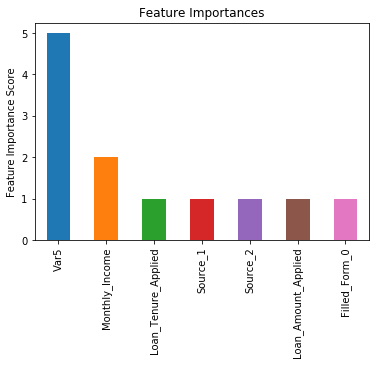

In [53]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

In [55]:
param_test1 = {
    'max_depth':np.arange(3,10,2),
    'min_child_weight':np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': array([3, 5, 7, 9]), 'min_child_weight': array([1, 3, 5])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [56]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83788, std: 0.00888, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83662, std: 0.00955, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83736, std: 0.00843, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84122, std: 0.00837, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84133, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84037, std: 0.00626, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83630, std: 0.00686, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83527, std: 0.00690, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83657, std: 0.00615, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82714, std: 0.00635, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82677, std: 0.00668, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83054, std: 0.00682, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 3